In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'original/processed')
OUT_DIR = Path('./out/pca')

if not OUT_DIR.exists():
    OUT_DIR.mkdir(parents=True) 

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 10

# Helper Functions

In [2]:
# def plot_km_results(cluster_count, labels, series):
#     plot_count = math.ceil(math.sqrt(cluster_count))
#     fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
#     fig.suptitle('Clusters')
#     row_i=0
#     column_j=0
#     # For each label there is,
#     # plots every series with that label
#     for label in set(labels):
#         cluster = []
#         for i in range(len(labels)):
#             if(labels[i]==label):
#                 axs[row_i, column_j].plot(series[i],c="gray",alpha=0.4)
#                 cluster.append(series[i])
#         if len(cluster) > 0:
#             axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
#         axs[row_i, column_j].set_title("Cluster "+str(row_i*plot_count+column_j))
#         column_j+=1
#         if column_j%plot_count == 0:
#             row_i+=1
#             column_j=0
#     plt.tight_layout()
#     plt.show()    
    
# def plot_unscaled_clusters(labels, nclusters, flows_dict, columns, save_path=None):
#     """Plot cluster of the original data (not scaled)"""  
    
#     fig, axs = plt.subplots(nrows=nclusters, ncols=len(columns), figsize=(5*len(columns), 5*nclusters))
#     for idx, flow in enumerate(flows_dict.values()):
#         for col_pos, col in enumerate(columns):
#             axs[(labels[idx], col_pos)].plot(flow[col], linewidth=0.5)
#             axs[(labels[idx], col_pos)].set(ylabel=col, title=f'Cluster {labels[idx]}')
            
#     plt.tight_layout()
    
#     if save_path != None:
#         plt.savefig(save_path, dpi=200)
    
#     plt.show()
    
# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

    # # create the counts of samples under each node
    # counts = np.zeros(model.children_.shape[0])
    # n_samples = len(model.labels_)
    # for i, merge in enumerate(model.children_):
    #     current_count = 0
    #     for child_idx in merge:
    #         if child_idx < n_samples:
    #             current_count += 1  # leaf node
    #         else:
    #             current_count += counts[child_idx - n_samples]
    #     counts[i] = current_count

    # linkage_matrix = np.column_stack([model.children_, model.distances_,
    #                                   counts]).astype(float)

    # # Plot the corresponding dendrogram
    # dendrogram(linkage_matrix, **kwargs)

# Load data

In [3]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, skiprows=2, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])

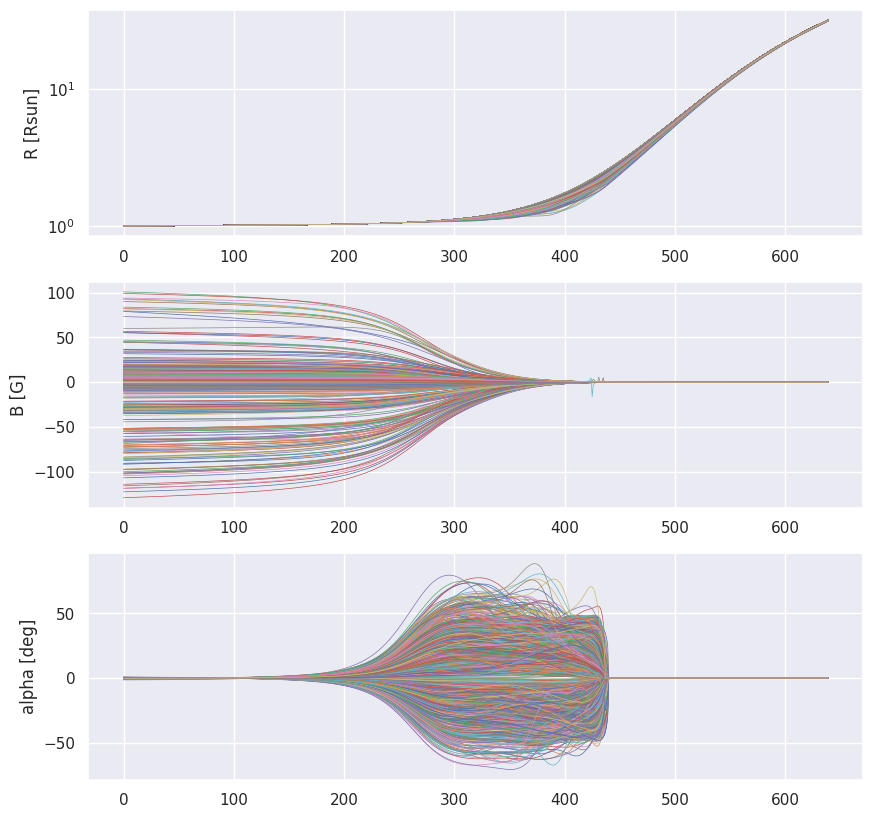

In [4]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for idx, col in enumerate(flow_columns):
    for series in flows_dict.values():
        axs[idx].plot(series.index, series[col], linewidth=0.5)
        
axs[0].set_ylabel('R [Rsun]')
axs[1].set_ylabel('B [G]')
axs[2].set_ylabel('alpha [deg]')

axs[0].set_yscale('log')
# axs[1].set_yscale('log')
# axs[2].set_yscale('symlog')


## Scale Inputs

In [5]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

for series in flows_dict.values():
    scaled_flows = pd.concat([scaled_flows, series], axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)


scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(754560, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.968204     0.189974
1  0.002002  0.968186     0.190101
2  0.003003  0.968168     0.190250
3  0.005005  0.968151     0.190444
4  0.006095  0.968133     0.190643


# Magnetic Field - B [G]

In [6]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]

array([0.96820388, 0.96818613, 0.96816834, 0.9681505 , 0.96813262])

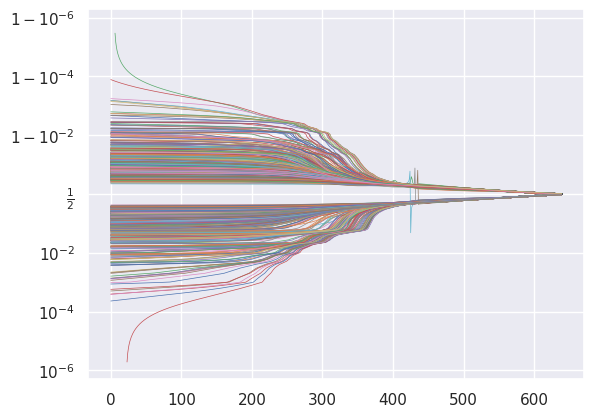

In [7]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

plt.yscale('logit')

## PCA

In [8]:
pca = PCA(n_components=2)
transformed_mag = pca.fit_transform(scaled_magnetic)
transformed_mag

array([[ 8.53601167,  0.30810988],
       [ 8.64248072,  0.37250197],
       [-6.50252847,  0.33203426],
       ...,
       [ 7.06525902, -0.12700837],
       [-7.98260783,  0.01260208],
       [ 9.66498653,  0.49934703]])

<AxesSubplot: >

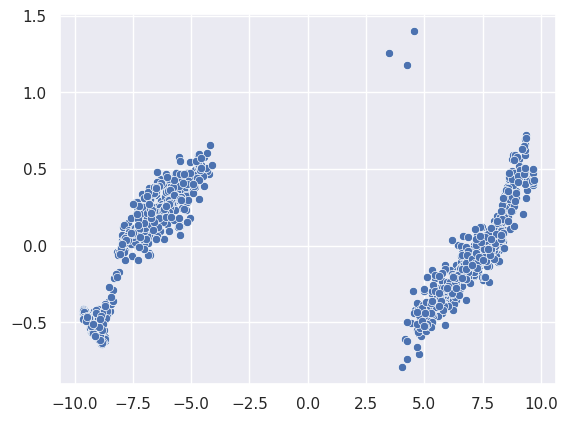

In [9]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

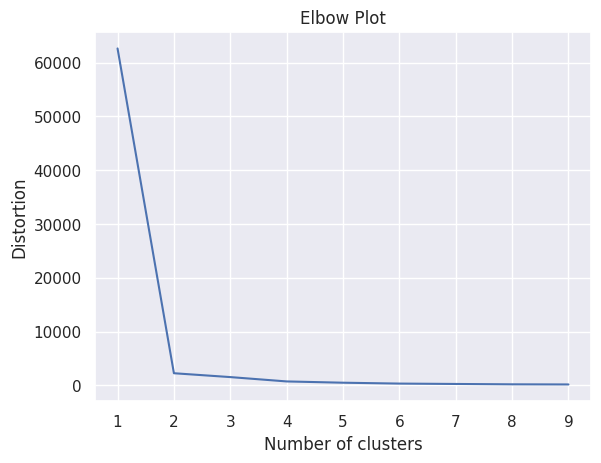

In [10]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_mag)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [11]:
kmeans = KMeans(n_clusters=2,max_iter=5000)

pca_kmeans_mag_labels = kmeans.fit_predict(transformed_mag)

/home/ivsaav/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: >

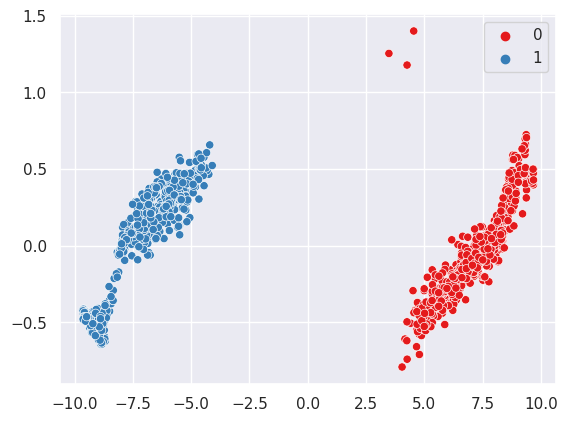

In [12]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=pca_kmeans_mag_labels, palette='Set1')

### Original Data

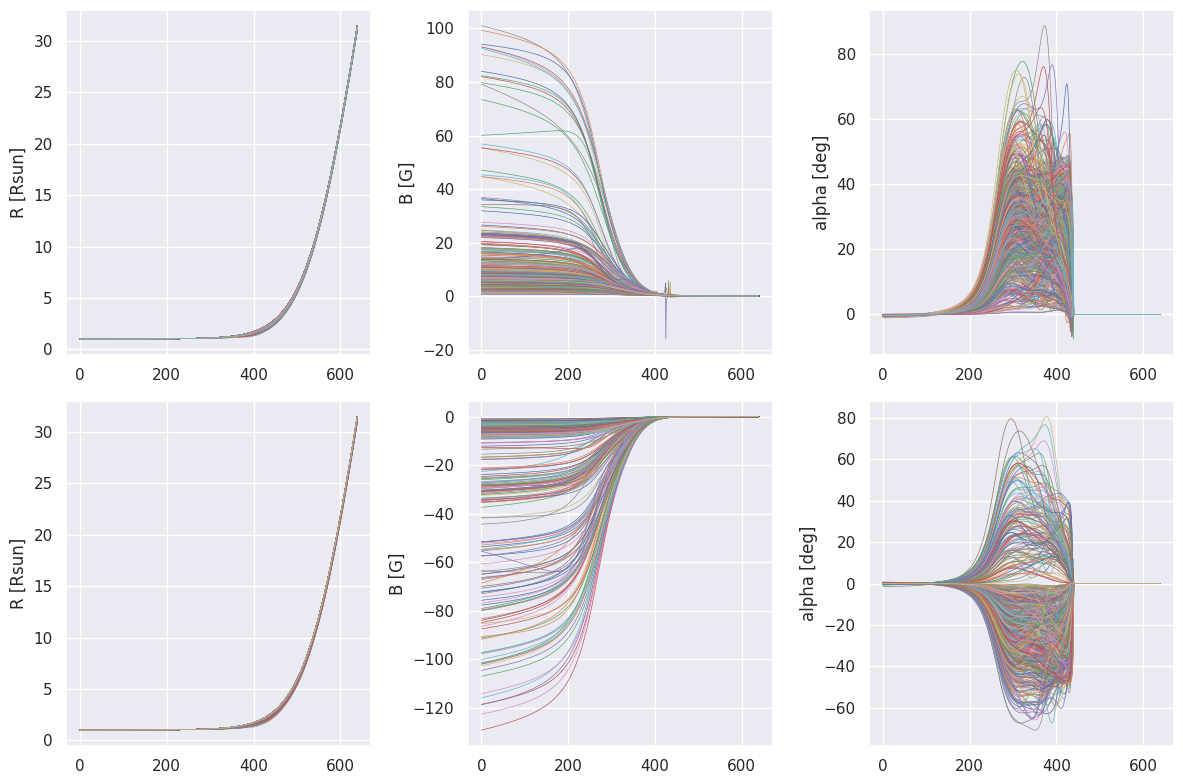

In [13]:
plot_unscaled_clusters(pca_kmeans_mag_labels, 2, flows_dict, flow_columns)

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

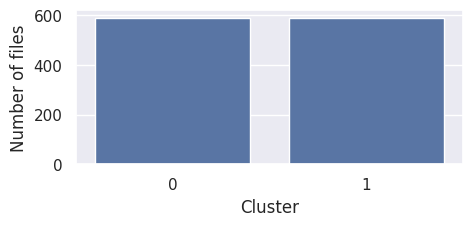

In [14]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_mag_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [15]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=5, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_mag)

Text(0.5, 0, 'Number of points in node')

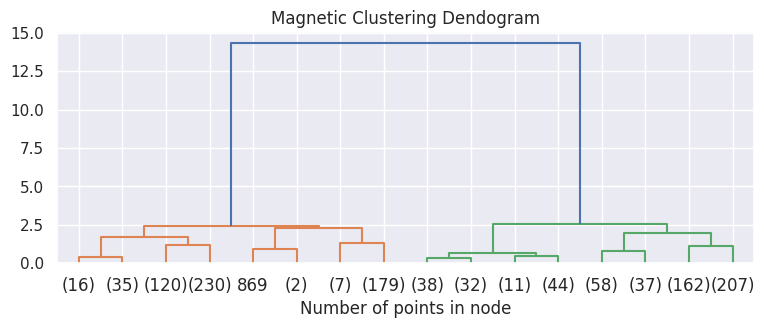

In [16]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

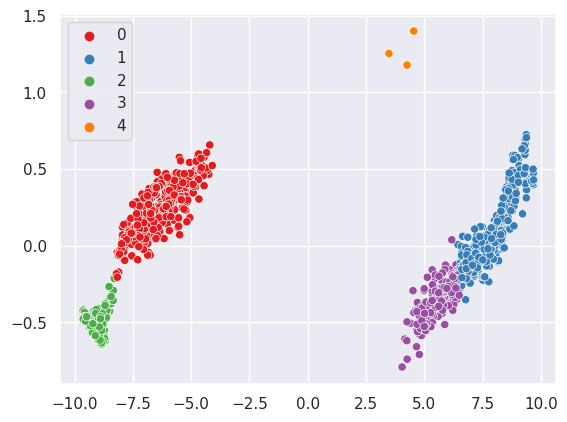

In [17]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

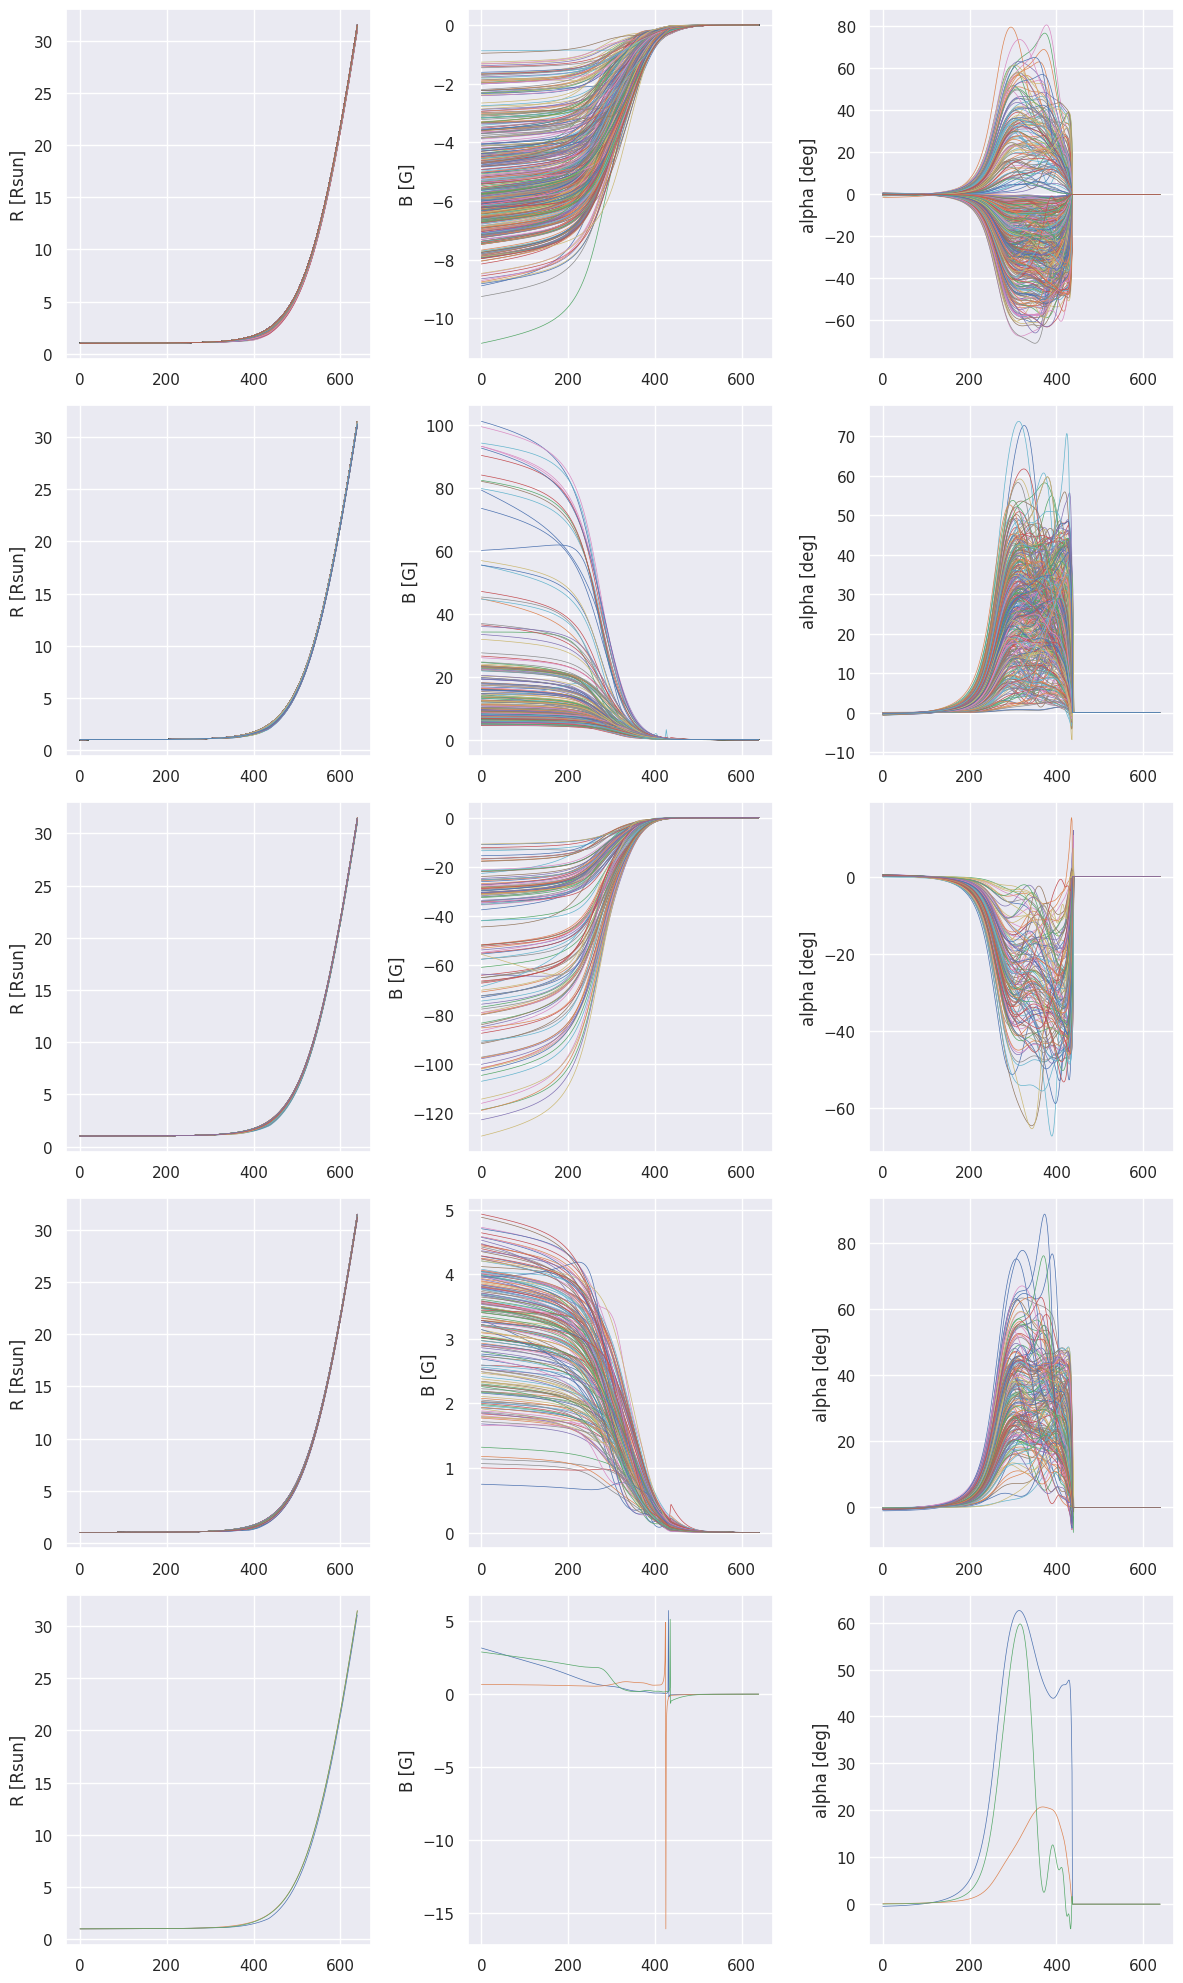

In [18]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

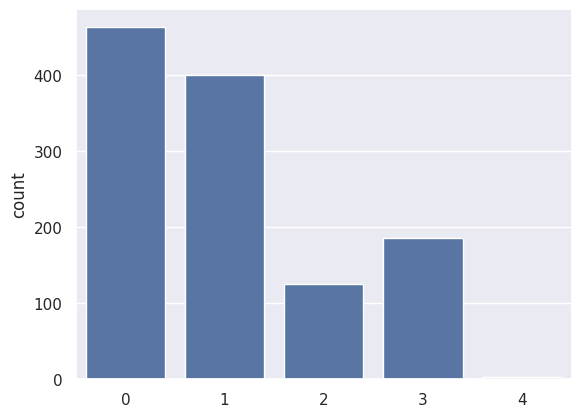

In [19]:
sns.countplot(x=agg.labels_, color='b')

In [20]:
%%capture
sub_dir = OUT_DIR / 'mag'
if not sub_dir.exists():
    sub_dir.mkdir()
    
for i in range(2, MAX_CLUSTERS):
    agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
    agg = agg.fit(transformed_mag)
    
    sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
    
        
    plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
    plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png') 
    

## DBSCAN

In [21]:
dbscan = DBSCAN(eps=0.2, min_samples=5, n_jobs=2)
dbscan_mag_labels = dbscan.fit_predict(transformed_mag)

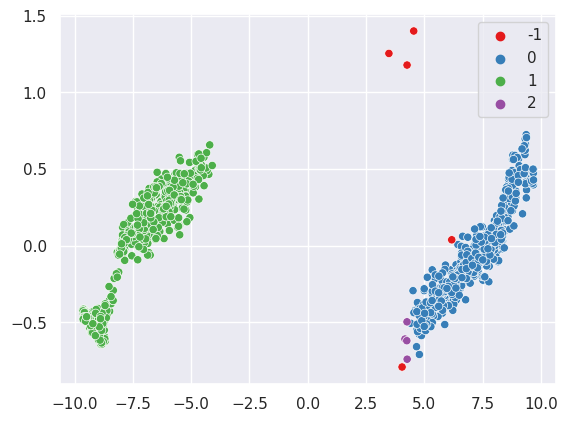

In [22]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=dbscan_mag_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

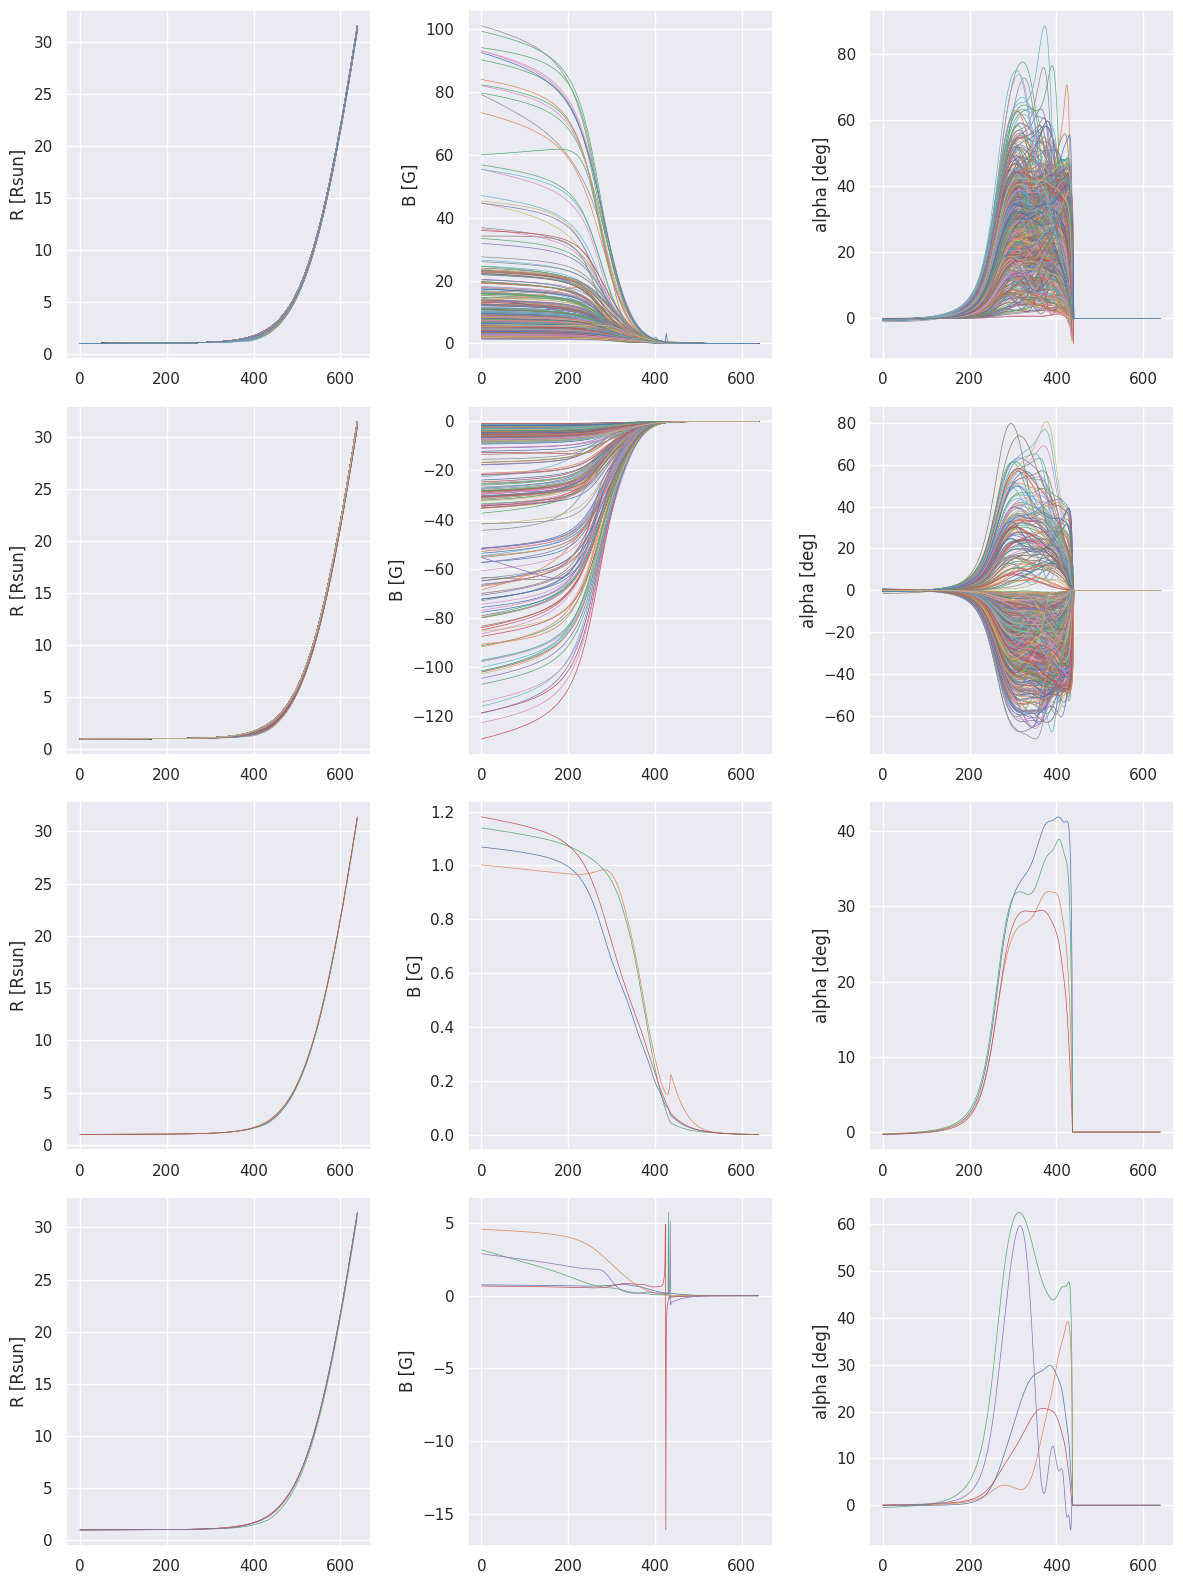

In [23]:
plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

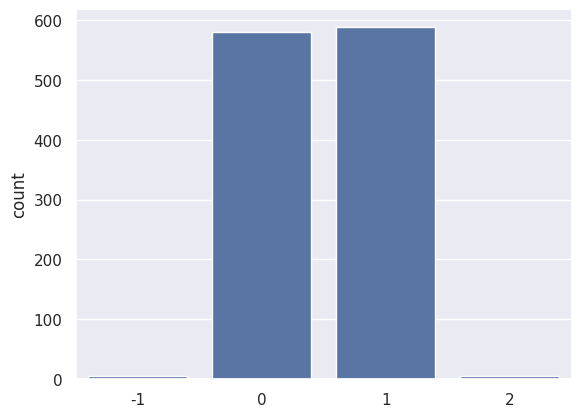

In [24]:
sns.countplot(x=dbscan_mag_labels, color='b')

In [25]:
%%capture
sub_dir = OUT_DIR / 'mag_dbscan'
if not sub_dir.exists():
    sub_dir.mkdir()

for i in np.arange(0.1, 0.35, 0.05):
    dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
    dbscan_mag_labels = dbscan.fit_predict(transformed_mag)
    
    save_i = int(i*100)
    sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=dbscan_mag_labels, palette='Set1')
    plt.legend(loc='upper right')
    plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
    plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns, save_path=sub_dir / f'dbscan_{save_i}.png')
    

# Flux Tube Inclination - alpha [deg]

In [26]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.18997379, 0.19010091, 0.19024982, 0.19044399, 0.19064283])

## PCA

In [27]:
pca = PCA(n_components=2)
transformed_alpha = pca.fit_transform(scaled_alpha)
transformed_alpha

array([[-5.78124046,  1.05557147],
       [-5.35959   ,  1.27965945],
       [ 7.97026991,  0.23229481],
       ...,
       [-6.33341045, -0.15571936],
       [ 7.28054337,  0.54509537],
       [-5.95589228,  0.6898801 ]])

### Transformed

<AxesSubplot: >

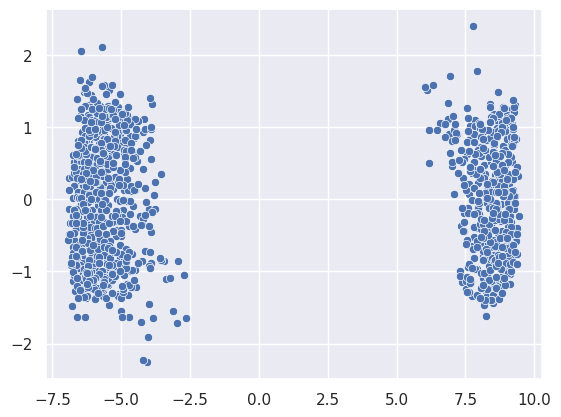

In [28]:
sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

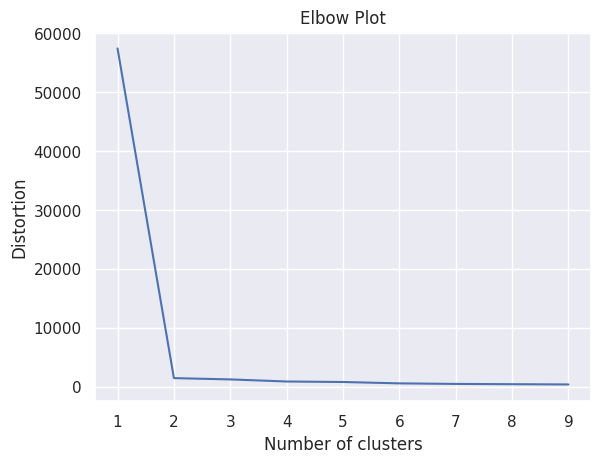

In [29]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_alpha)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [30]:
kmeans = KMeans(n_clusters=2,max_iter=5000, n_init='auto')

pca_kmeans_alpha_labels = kmeans.fit_predict(transformed_alpha)

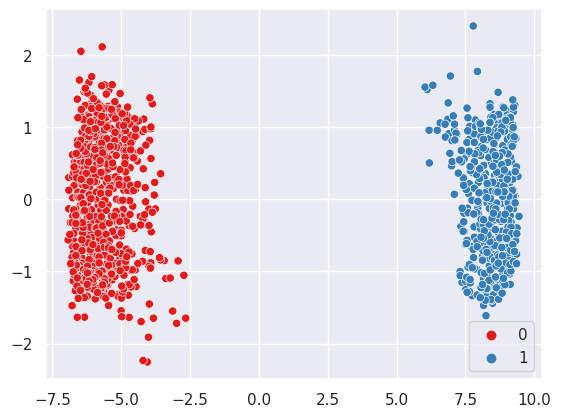

In [31]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=pca_kmeans_alpha_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

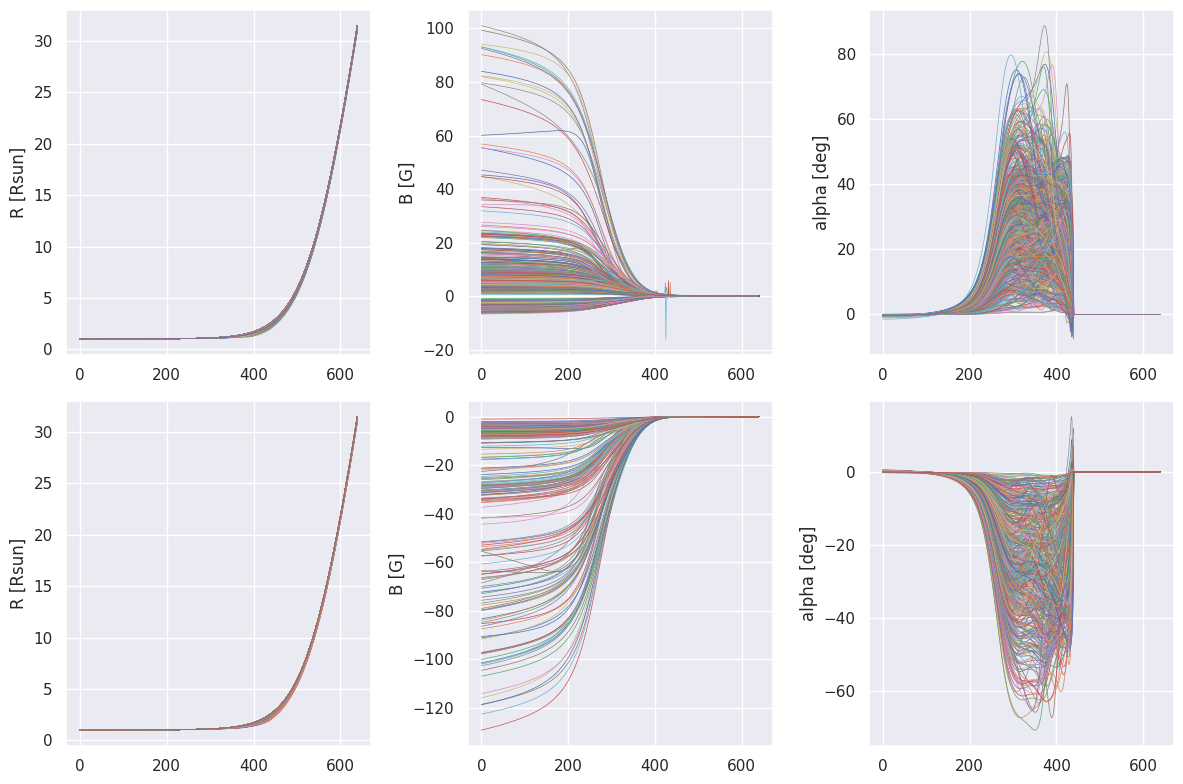

In [32]:
plot_unscaled_clusters(pca_kmeans_alpha_labels, 2, flows_dict, flow_columns)

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

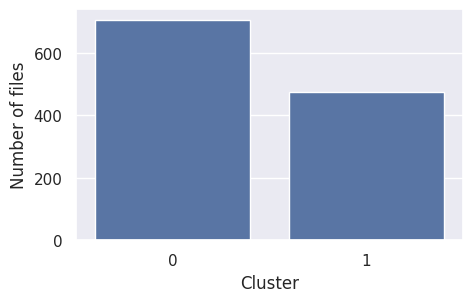

In [33]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

## Hierarchical Clustering

In [34]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='average')

agg = agg.fit(transformed_alpha)

Text(0.5, 0, 'Number of points in node')

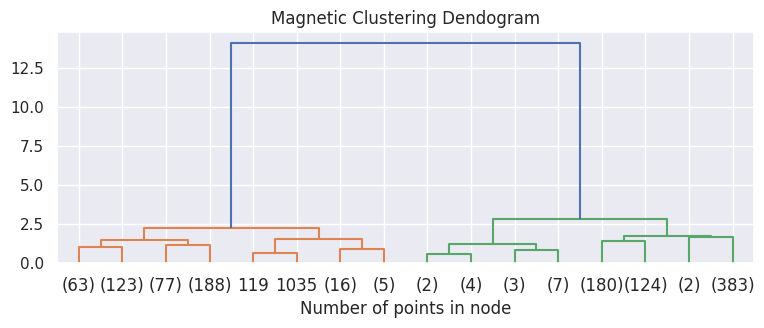

In [35]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

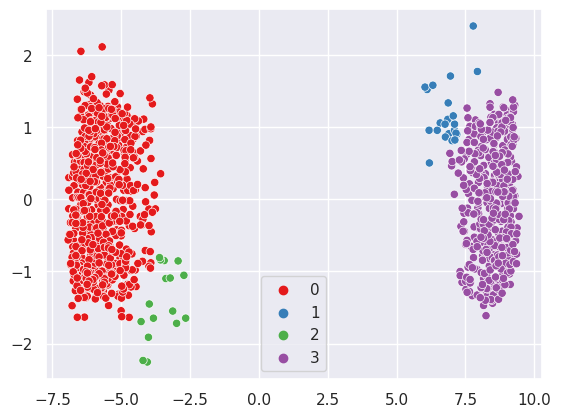

In [36]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

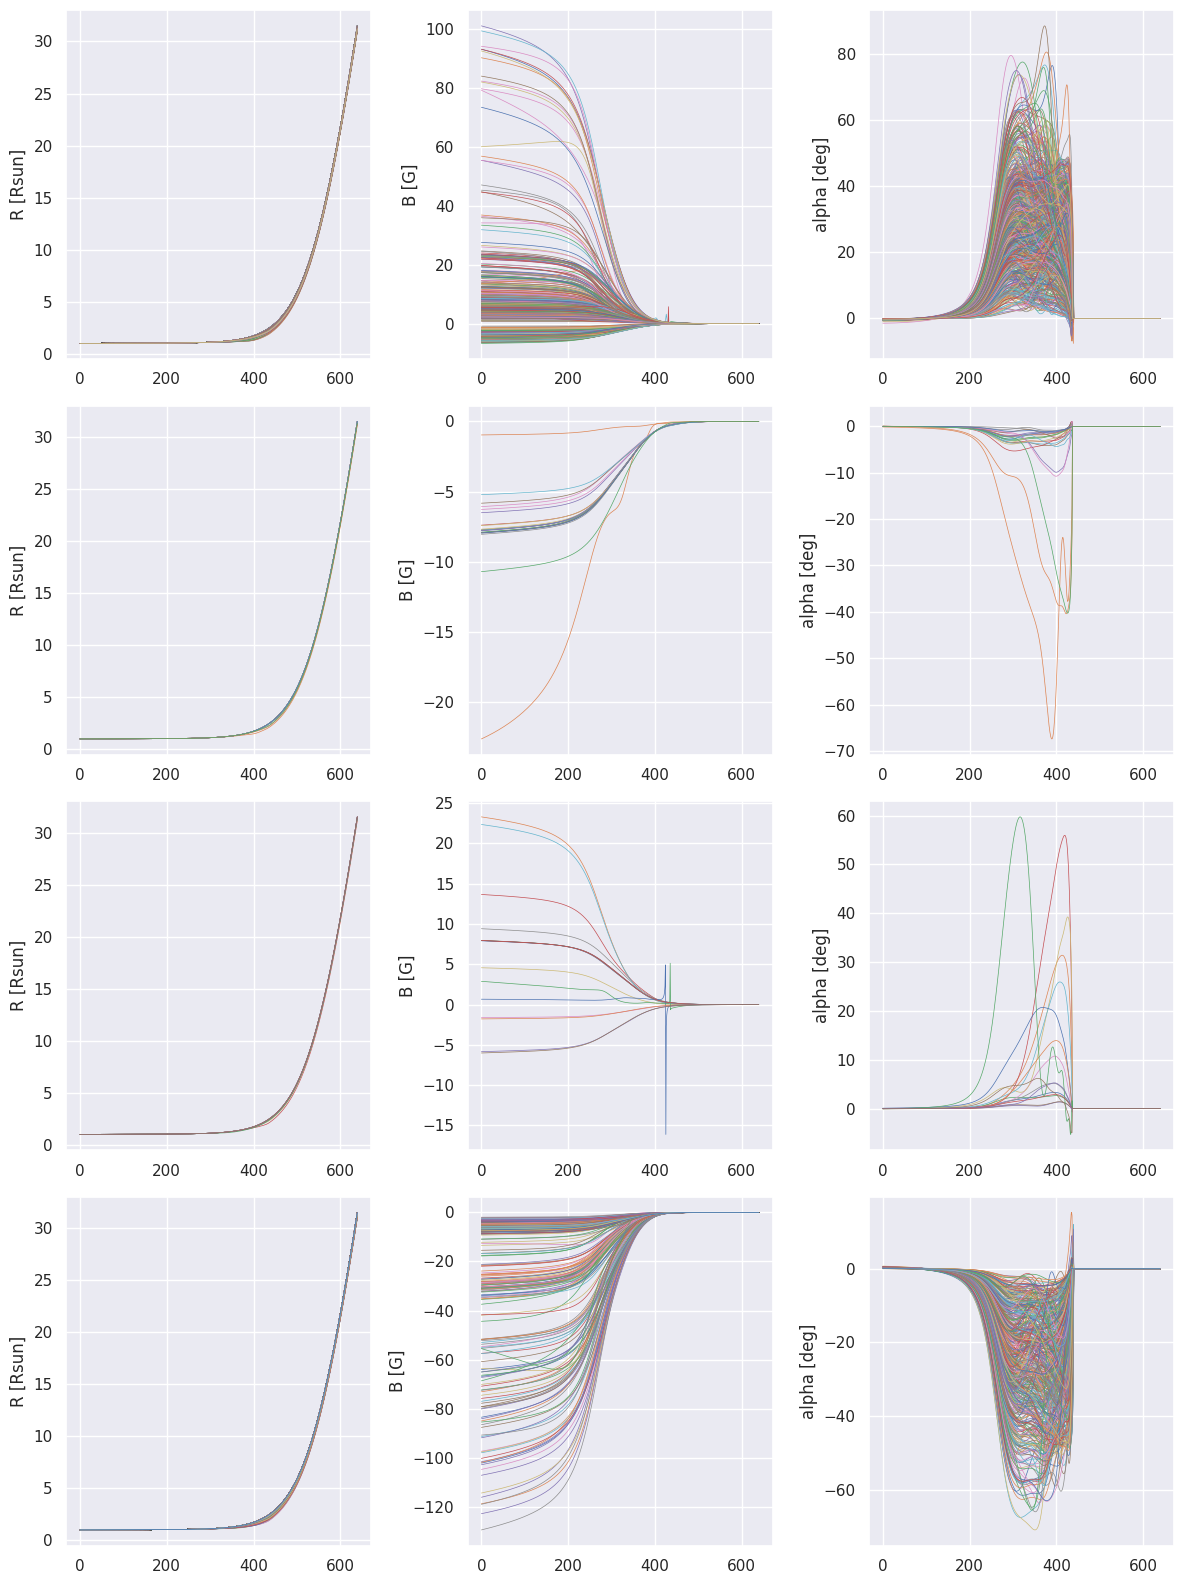

In [37]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

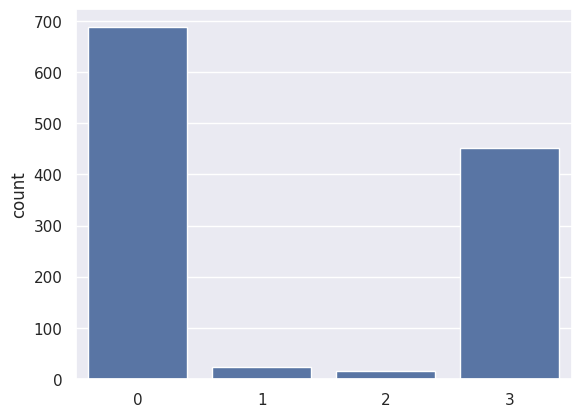

In [38]:
sns.countplot(x=agg.labels_, color='b')

In [39]:
%%capture
sub_dir = OUT_DIR / 'alpha'
if not sub_dir.exists():
    sub_dir.mkdir()
    
for i in range(2, MAX_CLUSTERS):
    agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
    agg = agg.fit(transformed_alpha)
    
    sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
    plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
    plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png') 
    

## DBSCAN

In [40]:
dbscan = DBSCAN(eps=0.25, min_samples=10, n_jobs=2)
dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)


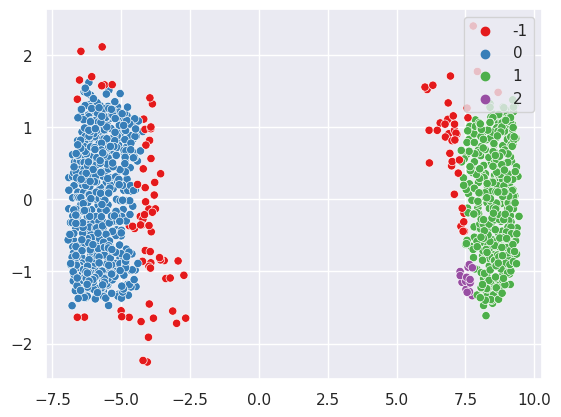

In [41]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

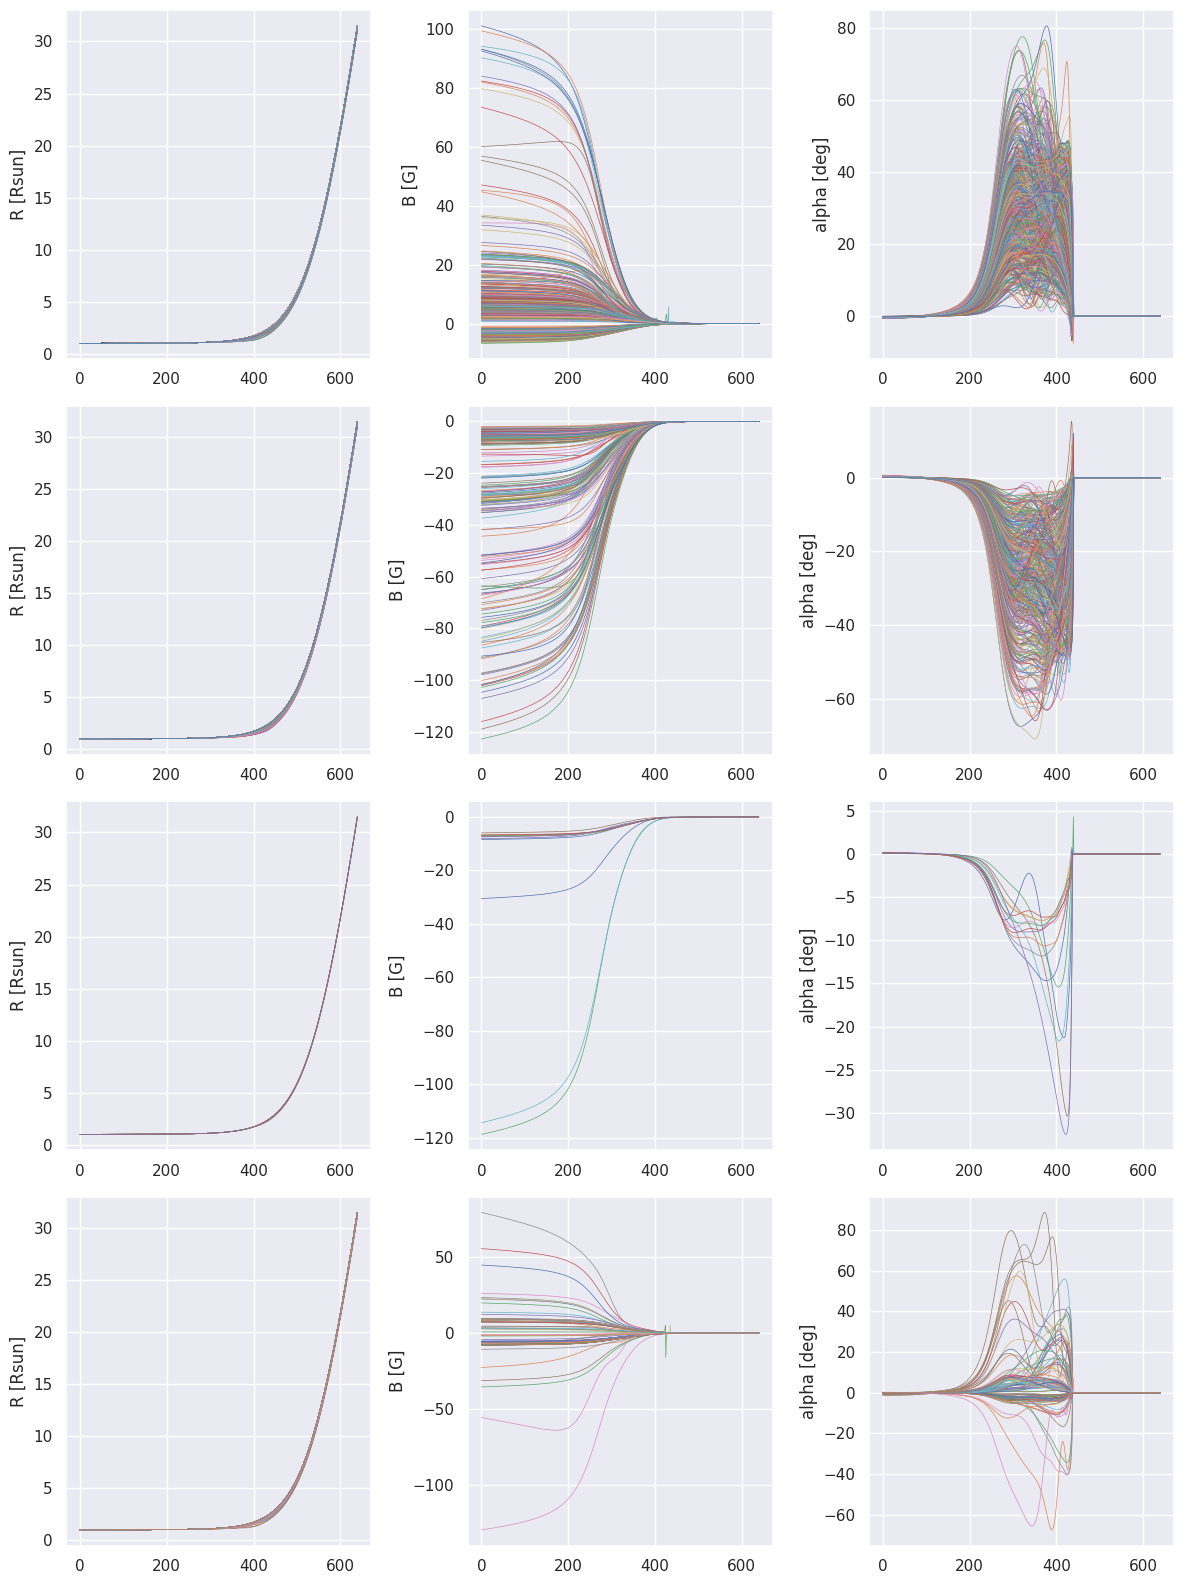

In [42]:
plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns)

### Cluster Distribution

<AxesSubplot: ylabel='count'>

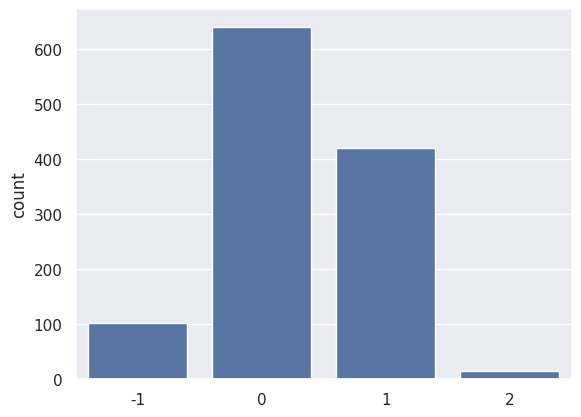

In [43]:
sns.countplot(x=dbscan_alpha_labels, color='b')

In [44]:
%%capture
sub_dir = OUT_DIR / 'alpha_dbscan'
if not sub_dir.exists():
    sub_dir.mkdir()
for i in np.arange(0.2, 0.5, 0.05):
    dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
    dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)
    
    save_i = int(round(i, 2) *100)
    sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
    plt.legend(loc='upper right')
    plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
    plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, save_path=sub_dir / f'dbscan_{save_i}.png')
    